In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

In [2]:
db = pd.read_csv('ibond/BDE_DB.csv', index_col=0)
bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0).drop_duplicates(
    subset=['molecule', 'fragment1', 'fragment2'])
benchmark = pd.read_csv('ibond/ibond_benchmark.csv', index_col=0)

In [3]:
# db.sort_values(by='BDE')

In [4]:
db = db.drop([106, 227, 238, 243, 281, 282, 700, 748]).reset_index()  # drop YF's outliers
db = db[db.ID.isin(benchmark.ID)]
db = db.dropna(subset=['Compound', 'Radical1', 'Radical2'])
db.head()

,ID,Compound,Radical1,Radical2,BDE,Error,Method,Solvent,B_Type,C_Struct,R1_Struct,R2_Struct
0,1,C,[CH3],[H],105.0,0.1,VLPP,gas,C-H,1,1,2.0
1,2,CC,C[C]([H])[H],[H],100.5,0.3,VLPP,gas,C-H,2,3,2.0
2,3,CCC,C[C]([H])C,[H],98.1,0.7,PIMS,gas,C-H,3,4,2.0
3,4,CCC,CC[C]([H])[H],[H],100.9,0.5,KM,gas,C-H,3,5,2.0
4,5,CC(C)C,C[C](C)C,[H],95.7,0.7,FS,gas,C-H,4,6,2.0


In [5]:
from bde.fragment import canonicalize_smiles, fragment_iterator, enumerate_stereocenters

In [6]:
db['Compound'] = db['Compound'].apply(canonicalize_smiles)
db['Radical1'] = db['Radical1'].apply(canonicalize_smiles)
db['Radical2'] = db['Radical2'].apply(canonicalize_smiles)

db = db.rename(columns=
          {'Compound': 'molecule',
           'Radical1': 'fragment1',
           'Radical2': 'fragment2',
          })

In [7]:
from rdkit import Chem

def check_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in ['C', 'H', 'N', 'O']:
            return False
        elif atom.GetFormalCharge() != 0:
            return False
    
    return True

db_valid = db[db.molecule.apply(check_mol)].copy()

In [8]:
ibond_mols = db_valid.molecule.unique()

def rdf_iterator():
    for smiles in tqdm_notebook(ibond_mols):
        for item in fragment_iterator(smiles):
            yield item 

rdf = pd.DataFrame(rdf_iterator())

In [9]:
rdf['radicals'] = rdf[['fragment1', 'fragment2']].apply(lambda x: str(sorted(list(x))), 1)
rdf = rdf.drop_duplicates('radicals')
db_valid['radicals'] = db_valid[['fragment1', 'fragment2']].apply(lambda x: str(sorted(list(x))), 1)

In [10]:
db_merged = db_valid.merge(rdf[['bond_index', 'radicals']], on='radicals', how='left').dropna(subset=['bond_index'])
db_merged['bond_index'] = db_merged.bond_index.astype(int)

In [11]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [12]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'rb') as f:
    preprocessor_data = pickle.load(f)
    
preprocessor = preprocessor_data['preprocessor']
inputs = preprocessor.predict(ibond_mols)

100%|██████████| 437/437 [00:00<00:00, 1799.81it/s]


In [13]:
import joblib
from keras.models import load_model
from nfp import custom_layers, GraphModel
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('layer_runs2/n_message_6/best_model.hdf5', custom_objects=custom_layers)
    embedding_model = GraphModel(model.inputs, [model.layers[-4].output])

bond_embed_df = pd.read_csv('20190604_bonds_for_neighbors.csv.gz')
nbrs_pipe = joblib.load('20190604_bond_embedding_nbrs.p.z')

def pipe_kneighbors(pipe, X):
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

In [14]:
from preprocessor_utils import ConcatGraphSequence
new_pred = model.predict_generator(
    ConcatGraphSequence(inputs, batch_size=128, shuffle=False), verbose=1)

new_embed = embedding_model.predict_generator(
    ConcatGraphSequence(inputs, batch_size=128, shuffle=False), verbose=1)

distances, indices = pipe_kneighbors(nbrs_pipe, new_embed)

4/4 [==============================] - 1s 126ms/step


In [15]:
def inputs_to_dataframe(smiles, inputs):
    molecule = np.repeat(np.array(smiles), np.stack([iinput['n_bond'] for iinput in inputs]))
    bond_index = np.concatenate([iinput['bond_indices'] for iinput in inputs])
    input_df = pd.DataFrame(np.vstack([molecule, bond_index]).T, columns=['molecule', 'bond_index'])
    input_df['bond_index'] = input_df.bond_index.astype('int64')
    
    return input_df

y_new_df = inputs_to_dataframe(ibond_mols, inputs)
y_new_df['bde_pred'] = new_pred
y_new_df['distance'] = np.log(distances).mean(1)

In [16]:
y_new_df = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
y_new_df.head()

,molecule,bond_index,bde_pred,distance
0,C,0,103.339211,3.829885
1,C,1,103.339211,3.829885
2,C,2,103.339211,3.829885
3,C,3,103.339211,3.829885
4,C#C,0,94.306419,3.545735


In [17]:
db_with_pred = db_merged.merge(
    y_new_df[['molecule', 'bond_index', 'bde_pred', 'distance']],
    on=['molecule', 'bond_index'], how='left')

db_with_pred.head()

,ID,molecule,fragment1,fragment2,BDE,Error,Method,Solvent,B_Type,C_Struct,R1_Struct,R2_Struct,radicals,bond_index,bde_pred,distance
0,1,C,[CH3],[H],105.0,0.1,VLPP,gas,C-H,1,1,2.0,"['[CH3]', '[H]']",0,103.339211,3.829885
1,2,CC,[CH2]C,[H],100.5,0.3,VLPP,gas,C-H,2,3,2.0,"['[CH2]C', '[H]']",1,99.346176,3.749039
2,3,CCC,C[CH]C,[H],98.1,0.7,PIMS,gas,C-H,3,4,2.0,"['C[CH]C', '[H]']",5,96.833183,3.712079
3,4,CCC,[CH2]CC,[H],100.9,0.5,KM,gas,C-H,3,5,2.0,"['[CH2]CC', '[H]']",2,100.117332,3.752526
4,5,CC(C)C,C[C](C)C,[H],95.7,0.7,FS,gas,C-H,4,6,2.0,"['C[C](C)C', '[H]']",6,95.093994,3.733527


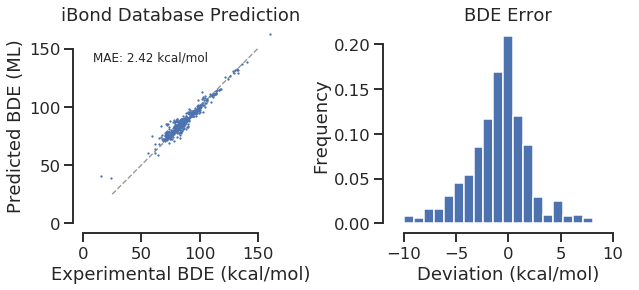

In [18]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121, aspect='equal')
plt.plot(db_with_pred.BDE, db_with_pred.bde_pred, '.', ms=2.5)
plt.plot([25, 150], [25, 150], '--', zorder=0, color='.6', lw=1.4)

ax.text(.05, .875,
        'MAE: {:0.2f} kcal/mol'.format(
            (db_with_pred.BDE - db_with_pred.bde_pred).abs().mean()),
        transform=ax.transAxes, ha='left', va='top', fontsize='large')

ax.set_yticks([0, 50, 100, 150])
ax.set_xticks([0, 50, 100, 150])


ax.set_ylabel('Predicted BDE (ML)')
ax.set_xlabel('Experimental BDE (kcal/mol)')
ax.set_title('iBond Database Prediction')


ax2 = fig.add_subplot(122)
ax2.hist((db_with_pred.BDE - db_with_pred.bde_pred).dropna(), bins=21, range=(-10, 10), density=True)

ax2.set_title('BDE Error')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Deviation (kcal/mol)')
ax2.set_xticks([-10, -5, 0, 5, 10])

plt.tight_layout()
sns.despine(trim=True, offset=10)
plt.savefig('ibond.svg', dpi=500)